In [1]:
import os
import itertools
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_curves_dict(curve_paths):
    # curve_paths -- a list of paths to curves in the format 
    #                */{model}_{dataset}_{ind1}_{ind2}_curve_{seed}
    curves = {}
    for i, curve_name in enumerate(curve_paths):
        curve = np.load(curve_name)
        curves[('_'.join(curve_name.split('/')[-1].split('_')[-4:-2]))] = curve
    return curves

In [3]:
def prepare_curves(curves, metric, complement=True, inverse=False):
    out_curves = {}
    for curve_ind in curves:
        ind1, ind2 = curve_ind.split('_')
        inv_curve_ind = '{}_{}'.format(ind2, ind1)
        
        if inverse:
            out_curves[inv_curve_ind] = curves[curve_ind][metric][::-1]
        else:
            out_curves[curve_ind] = curves[curve_ind][metric]
            if complement:
                out_curves[inv_curve_ind] = curves[curve_ind][metric][::-1]
    
    return out_curves

In [4]:
def get_barc_1chain(curves):
    barcode = {}
    counter = {}
    
    for curve_ind in curves:
        curve = curves[curve_ind]
        ind1, ind2 = curve_ind.split('_')
        value_ind1 = curve[0]
        value_ind2 = curve[-1]
        
        if ind1 not in barcode:
            barcode[ind1] = [0, np.inf]
            counter[ind1] = 0
        
        # update minimum value
        barcode[ind1][0] = barcode[ind1][0] * counter[ind1] + value_ind1
        counter[ind1] += 1
        barcode[ind1][0] /= counter[ind1]
        
        # update saddle value
        if value_ind1 > value_ind2:
            curve_max = curve.max()
            barcode[ind1][1] = min(barcode[ind1][1], curve_max)
        
    barcode = dict(sorted(barcode.items(), key=lambda item: item[1][1]))
            
    return barcode

In [5]:
def get_barc_2chain(barc1, curves1, curves2):
    barcode = {k : copy(barc1[k]) for k in barc1}
    
    for curve1_ind in curves1:
        curve1 = curves1[curve1_ind]
        curve1_max = curve1.max()
        
        ind1_1, ind1_2 = curve1_ind.split('_')
        value_ind1_1 = curve1[0]
        value_ind1_2 = curve1[-1]
        
        saddle = barcode[ind1_1][-1]
        
        if value_ind1_1 < value_ind1_2 and curve1_max < saddle:
            for curve2_ind in curves2:
                curve2 = curves2[curve2_ind]
                curve2_max = curve2.max()
                
                ind2_1, ind2_2 = curve2_ind.split('_')
                value_ind2_1 = curve2[0]
                value_ind2_2 = curve2[-1]
                
                if ind1_2 == ind2_1 and value_ind1_1 > value_ind2_2:
                    path_max = max(curve1_max, curve2_max)
                    barcode[ind1_1][-1] = min(barcode[ind1_1][-1], path_max)
                    
    barcode = dict(sorted(barcode.items(), key=lambda item: item[1][1]))
            
    return barcode

In [6]:
metric = 'tr_loss'

# ResNet9, CIFAR10

In [7]:
def compute_barcode(ann_curve_paths, const_curve_paths, annconst_curve_paths, metric, is_barc2=False, is_reduce=False):
    #########
    # part 1: compute barcode 1
    #########
    ann_curves = get_curves_dict(ann_curve_paths)
    ann_curves = prepare_curves(ann_curves, metric, complement=True, inverse=False)
    ann_barc1 = get_barc_1chain(ann_curves)

    const_curves = get_curves_dict(const_curve_paths)
    const_curves = prepare_curves(const_curves, metric, complement=True, inverse=False)
    const_barc1 = get_barc_1chain(const_curves)

    annconst_curves = get_curves_dict(annconst_curve_paths)
    constann_curves = prepare_curves(annconst_curves, metric, complement=False, inverse=True)
    constann_barc1 = get_barc_1chain(constann_curves)
    
    if not is_barc2:
        return ann_barc1, const_barc1, constann_barc1
    
    #########
    # part 2: compute barcode 2
    #########
    ann_curves = get_curves_dict(ann_curve_paths)
    const_curves = get_curves_dict(const_curve_paths)
    annconst_curves = get_curves_dict(annconst_curve_paths)
    
    # update ann-ann barcode 1
    # ann - ann - ann
    curves1 = prepare_curves(ann_curves, metric, complement=True, inverse=False)
    curves2 = prepare_curves(ann_curves, metric, complement=True, inverse=False)
    ann_barc2 = get_barc_2chain(ann_barc1, curves1, curves2)
    
    # ann - const - ann
    curves1 = prepare_curves(annconst_curves, metric, complement=False, inverse=False)
    curves2 = prepare_curves(annconst_curves, metric, complement=False, inverse=True)
    ann_barc2 = get_barc_2chain(ann_barc2, curves1, curves2)
    
    # update const-const barcode 1
    # const - const - const
    curves1 = prepare_curves(const_curves, metric, complement=True, inverse=False)
    curves2 = prepare_curves(const_curves, metric, complement=True, inverse=False)
    const_barc2 = get_barc_2chain(const_barc1, curves1, curves2)

    # const - ann - const
    curves1 = prepare_curves(annconst_curves, metric, complement=False, inverse=True)
    curves2 = prepare_curves(annconst_curves, metric, complement=False, inverse=False)
    const_barc2 = get_barc_2chain(const_barc2, curves1, curves2)
    
    # update const-ann barcode 1
    # const - ann - ann
    curves1 = prepare_curves(annconst_curves, metric, complement=False, inverse=True)
    curves2 = prepare_curves(ann_curves, metric, complement=True, inverse=False)
    constann_barc2 = get_barc_2chain(constann_barc1, curves1, curves2)
    
    # const - const - ann
    curves1 = prepare_curves(const_curves, metric, complement=True, inverse=False)
    curves2 = prepare_curves(annconst_curves, metric, complement=False, inverse=True)
    constann_barc2 = get_barc_2chain(constann_barc2, curves1, curves2)
    
    if not is_reduce:
        return ann_barc2, const_barc2, constann_barc2
    
    for min_ind in const_barc2:
        const_barc2[min_ind][-1] = min(const_barc2[min_ind][-1], constann_barc2[min_ind][-1])
        
    const_barc2 = dict(sorted(const_barc2.items(), key=lambda item: item[1][1]))
        
    return ann_barc2, const_barc2

In [8]:
def plot_barcodes(ann_barc, const_barc, constann_barc=None):
    fig, ax = subplots(nrows=1, ncols=1, figsize=(20, 10))
    infinity = 1e5
    ymin = 1e10
    ymax = -1e10
    for i, min_ind in enumerate(const_barc):
        min_value = const_barc[min_ind][0]
        saddle_value1 = min(const_barc[min_ind][-1], infinity)
        scatter(i, min_value, marker='*', c='red')
        scatter(i, saddle_value1, marker='v', c='mediumblue')
        vlines(i, min_value, saddle_value1, colors='gray', linestyle='--', alpha=0.2)
        ymin = min(ymin, min_value)
        if saddle_value1 < infinity:
            ymax = max(ymax, saddle_value1)
        if constann_barc:
            saddle_value2 = min(constann_barc[min_ind][-1], infinity)
            scatter(i, saddle_value2, marker='v', c='#FFA500')
            if saddle_value2 < infinity:
                ymax = max(ymax, saddle_value2)
    scatter(i, min_value, marker='*', c='red', label='Loss at minimum')
    scatter(i, saddle_value1, marker='v', c='mediumblue', label='Loss at saddle')
    if constann_barc:
        scatter(i, saddle_value2, marker='v', c='#FFA500', label='Loss at saddle (1)->(2)')
    vlines(i + 0.5, ymin=0, ymax=1.2, colors='red', linewidth=5, alpha=0.2)
    for i, min_ind in enumerate(ann_barc):
        min_value = ann_barc[min_ind][0]
        saddle_value = min(ann_barc[min_ind][-1], infinity)
        scatter(i + len(const_barc), min_value, marker='*', c='red')
        scatter(i + len(const_barc), saddle_value, marker='v', c='mediumblue')
        vlines(i + len(const_barc), min_value, saddle_value, colors='gray', linestyle='--', alpha=0.2)
        ymin = min(ymin, min_value)
        if saddle_value < infinity:
            ymax = max(ymax, saddle_value)
    _ = xticks(ticks=[3, 11.5], labels=['Small LR', 'Annealing of LR'], fontsize=25)
    ylabel('Cross-entropy', fontsize=20)
    legend(loc=1, prop={'size': 15})   
    ylim(ymin-0.01, ymax+0.05)

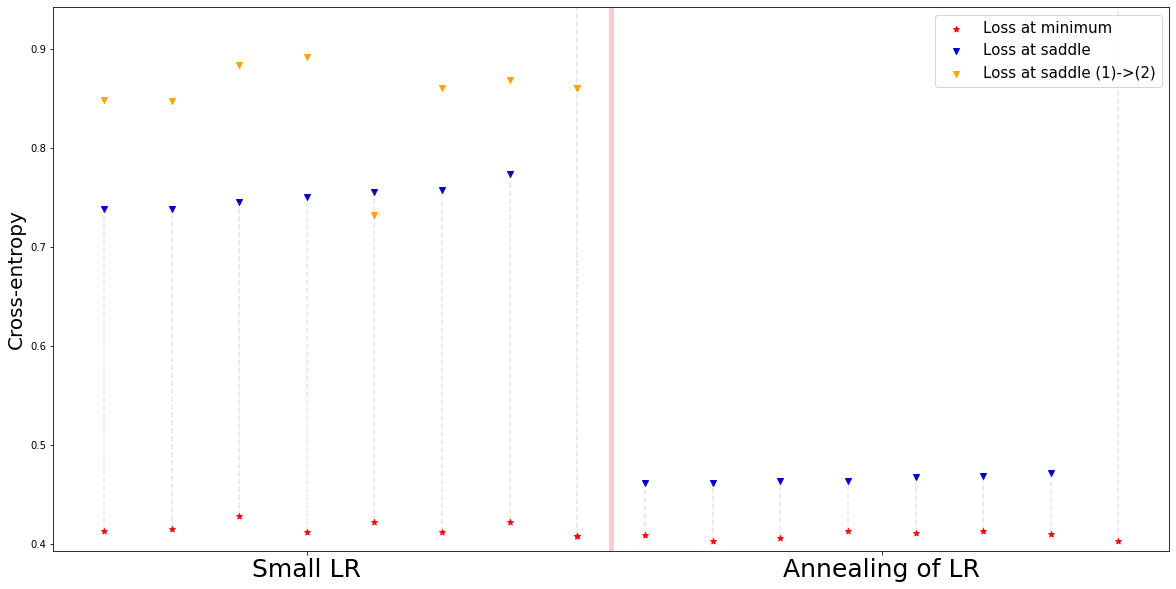

In [9]:
cur_dir = './eval/'
ann_curve_paths = sorted([os.path.join(cur_dir, fn) for fn in os.listdir(cur_dir) 
                      if 'annResNet9_CIFAR10' in fn and 'curve' in fn])
const_curve_paths = sorted([os.path.join(cur_dir, fn) for fn in os.listdir(cur_dir) 
                      if 'constResNet9_CIFAR10' in fn and 'curve' in fn and 'ann' not in fn])
annconst_curve_paths = sorted([os.path.join(cur_dir, fn) for fn in os.listdir(cur_dir) 
                      if 'annconstResNet9_CIFAR10' in fn and 'curve' in fn])
ann_barc1, const_barc1, constann_barc1 = compute_barcode(ann_curve_paths, const_curve_paths, annconst_curve_paths, metric, is_barc2=False)
plot_barcodes(ann_barc1, const_barc1, constann_barc1)

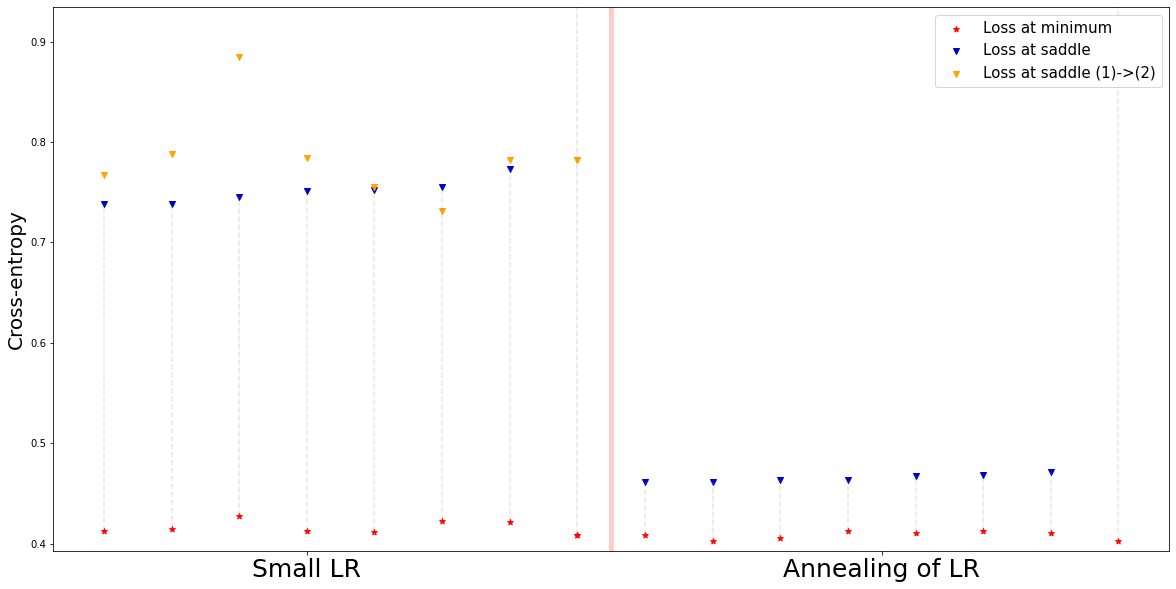

In [10]:
ann_barc2, const_barc2, constann_barc2 = compute_barcode(ann_curve_paths, const_curve_paths, annconst_curve_paths, metric, is_barc2=True, is_reduce=False) 
plot_barcodes(ann_barc2, const_barc2, constann_barc2)

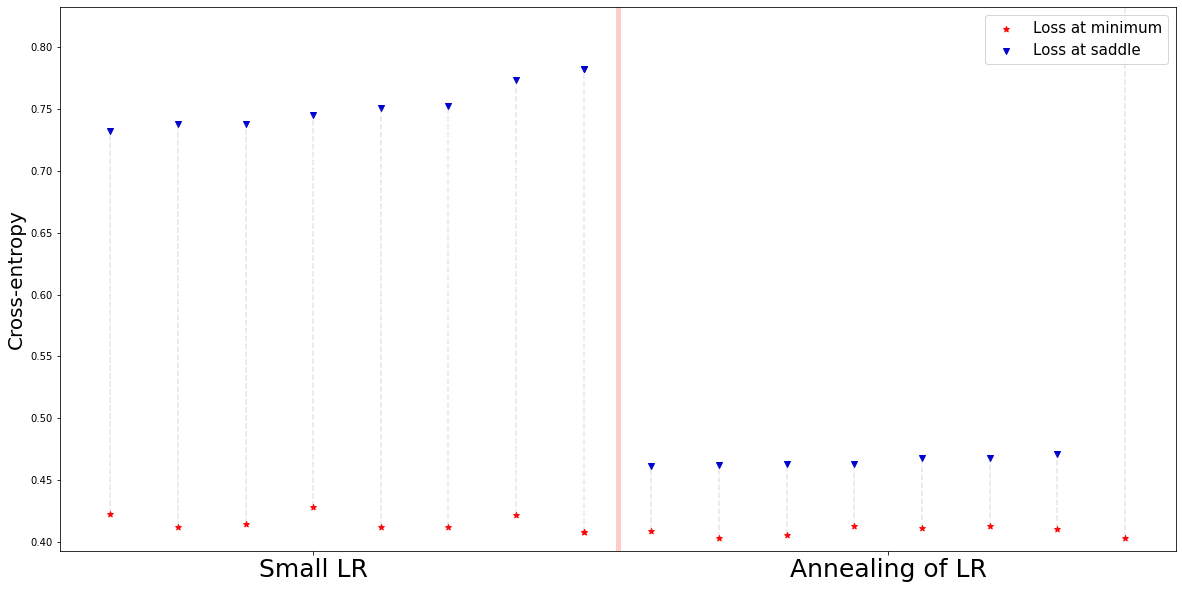

In [11]:
ann_barc, const_barc = compute_barcode(ann_curve_paths, const_curve_paths, annconst_curve_paths, metric, is_barc2=True, is_reduce=True) 
plot_barcodes(ann_barc, const_barc)
savefig("ResNet9_CIFAR10_barcode.png")

# ResNet9, SVHN

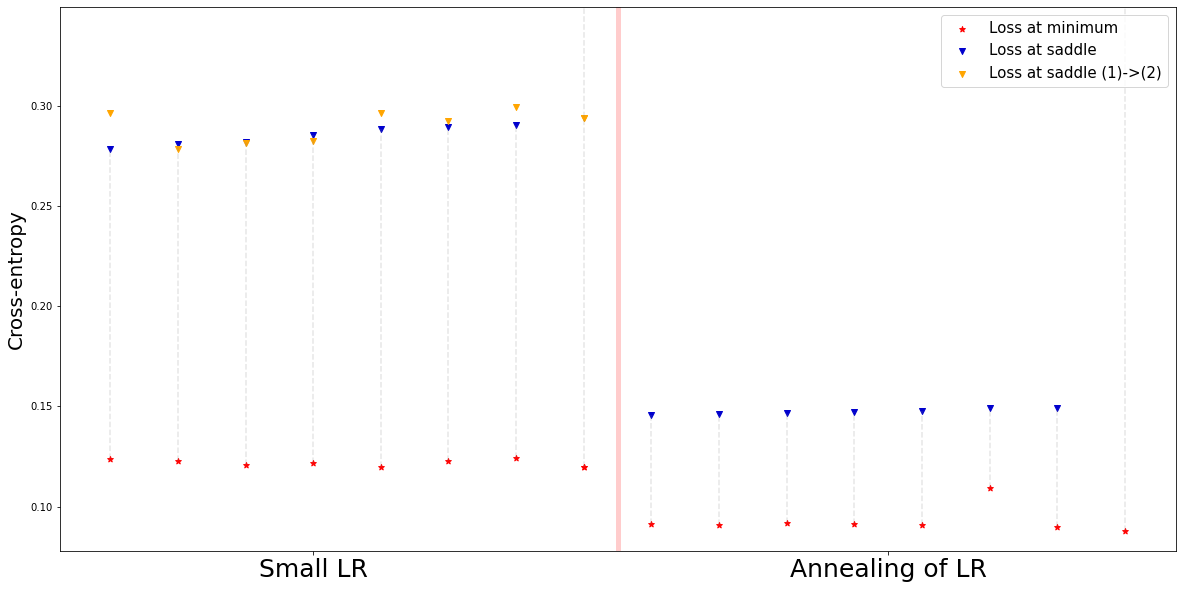

In [12]:
cur_dir = './eval/'
ann_curve_paths = sorted([os.path.join(cur_dir, fn) for fn in os.listdir(cur_dir) 
                      if 'annResNet9_SVHN' in fn and 'curve' in fn])
const_curve_paths = sorted([os.path.join(cur_dir, fn) for fn in os.listdir(cur_dir) 
                      if 'constResNet9_SVHN' in fn and 'curve' in fn and 'ann' not in fn])
annconst_curve_paths = sorted([os.path.join(cur_dir, fn) for fn in os.listdir(cur_dir) 
                      if 'annconstResNet9_SVHN' in fn and 'curve' in fn])
ann_barc1, const_barc1, constann_barc1 = compute_barcode(ann_curve_paths, const_curve_paths, annconst_curve_paths, metric, is_barc2=False)
plot_barcodes(ann_barc1, const_barc1, constann_barc1)

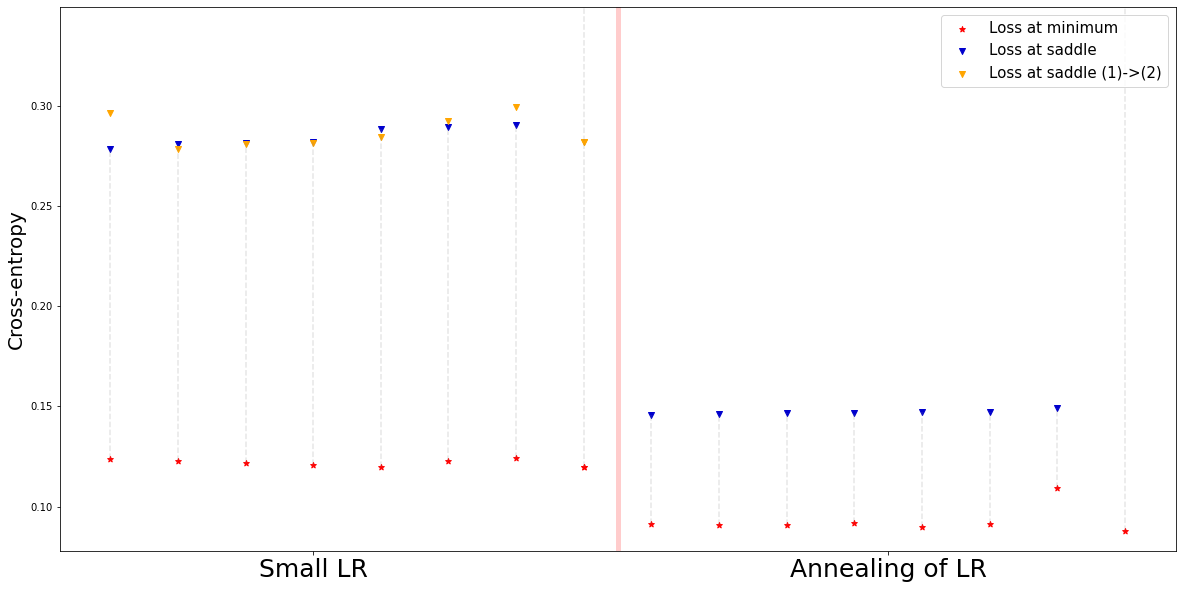

In [13]:
ann_barc2, const_barc2, constann_barc2 = compute_barcode(ann_curve_paths, const_curve_paths, annconst_curve_paths, metric, is_barc2=True, is_reduce=False) 
plot_barcodes(ann_barc2, const_barc2, constann_barc2)

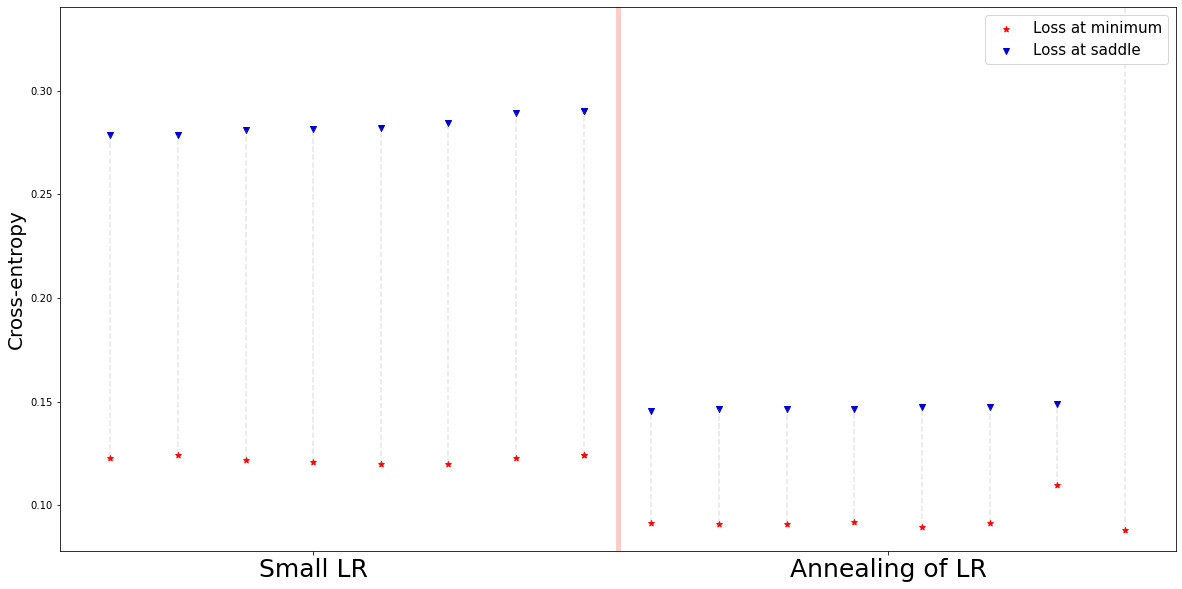

In [15]:
ann_barc, const_barc = compute_barcode(ann_curve_paths, const_curve_paths, annconst_curve_paths, metric, is_barc2=True, is_reduce=True) 
plot_barcodes(ann_barc, const_barc)
savefig("ResNet9_SVHN_barcode.png")

# WideResNet16x10, CIFAR100

In [27]:
def get_triangle_dict(triangle_paths):
    triangles = {}
    for i, triangle_name in enumerate(triangle_paths):
        triangle = np.load(triangle_name)
        triangles[('_'.join(triangle_name.split('/')[-1].split('_')[2:5]))] = triangle
    return triangles

def compute_triangle_barcode(triangle):
    side0_index = np.where(np.abs(triangle['ts'][:, 0]) < 1e-10)[0]
    side1_index = np.where(np.abs(triangle['ts'][:, 1]) < 1e-10)[0]    
    side2_index = np.where(np.abs(triangle['ts'][:, 2]) < 1e-10)[0]
    print (side0_index.shape, side1_index.shape, side2_index.shape)
    
    side0_max = triangle['tr_loss'][side0_index].max()
    side1_max = triangle['tr_loss'][side1_index].max()
    side2_max = triangle['tr_loss'][side2_index].max()
    
    v1 = max(side0_max, side1_max, side2_max)
    v2 = triangle['tr_loss'].max()
    
    barcode = [v1, v2]
    
    return barcode

In [28]:
cur_dir = './eval/'
curve_paths = sorted([os.path.join(cur_dir, fn) for fn in os.listdir(cur_dir) 
                      if 'WideResNet16x10_CIFAR100' in fn and 'curve' in fn])

In [31]:
curves = get_curves_dict(curve_paths)
curves = prepare_curves(curves, metric, complement=True, inverse=False)
barc1 = get_barc_1chain(curves)
barcode = get_barc_2chain(barc1, curves, curves)
barcode

{'2': array([0.25082257, 0.40446848]),
 '4': array([0.21967322, 0.40447363]),
 '1': array([0.198537  , 0.40969753]),
 '3': array([0.19714256, 0.41152878]),
 '0': array([0.19102686,        inf])}

In [30]:
triangle_paths = sorted([os.path.join(cur_dir, fn) for fn in os.listdir(cur_dir) 
                         if 'triangle' in fn and 'WideResNet16x10_CIFAR100' in fn])
print(triangle_paths)

triangles = get_triangle_dict(triangle_paths)
print(triangles)

triangle = triangles['0-1_0-2_1-2']

tr_barcode = compute_triangle_barcode(triangle)
print(tr_barcode)

['./eval/WideResNet16x10_CIFAR100_0-1_0-2_1-2_triangle_0.npz']
{'0-1_0-2_1-2': <numpy.lib.npyio.NpzFile object at 0x7f90257fcc50>}
(11,) (11,) (11,)
[0.45122402101516723, 0.6015263732528686]


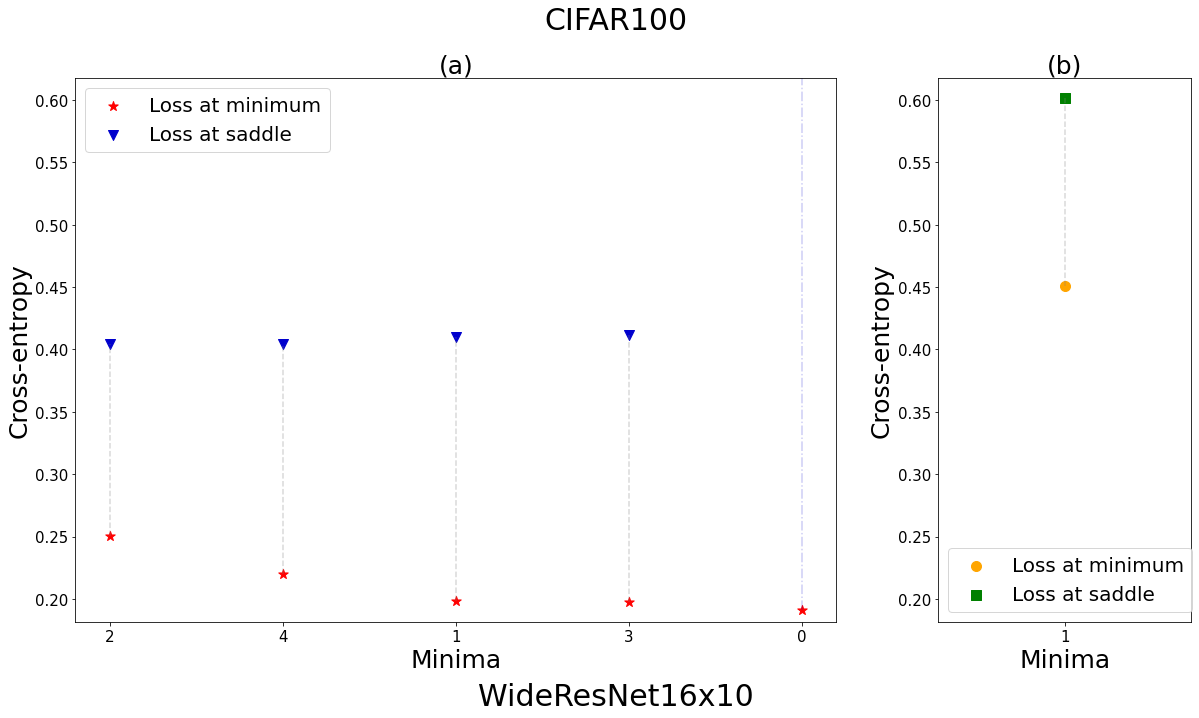

In [41]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 10))

max_value = np.array(list(barcode.values()))[:, 1][:-1].max()
min_value = np.array(list(barcode.values()))[:, 0].min()

x = np.arange(len(barcode))
y1 = np.array(list(barcode.values()))[:, 0]
ax[0].scatter(x, y1, marker="*", c='red', label = 'Loss at minimum', s=100)
y2 = np.array(list(barcode.values()))[:, -1]
ax[0].scatter(x, y2, marker="v", c='mediumblue', label = 'Loss at saddle', s=100)
ax[0].legend(loc=2, prop={'size': 20})

for i, min_ind in enumerate(barcode):
    y_max = min(max_value + 1., barcode[min_ind][-1])
    if y_max == barcode[min_ind][-1]:
        ax[0].vlines(x=i, ymin=barcode[min_ind][0], ymax=y_max, colors='gray', linestyle='--', alpha = 0.3)
    else:
        ax[0].vlines(x=i, ymin=barcode[min_ind][0], ymax=y_max, colors='mediumblue', linestyle='-.', alpha=0.2)

ax[0].set_ylim([0.95*min_value, 1.5*max_value])
ylabel = 'Cross-entropy'
if 'loss' not in metric:
    ylabel += ' (no $L_2$)'
ax[0].set_ylabel(ylabel, size = 25)
ax[0].set_xticks(ticks=np.arange(len(barcode)))
ax[0].set_xticklabels(labels=map(str, list(barcode.keys())))

x = 1.
y1 = tr_barcode[0]
y2 = tr_barcode[1]

ax[1].vlines(x, ymin=y1, ymax=y2,  colors='gray', linestyle='--', alpha = 0.3)

ax[1].scatter(x, y1, marker="o", c='orange', label = 'Loss at minimum', s=100)
ax[1].scatter(x, y2, marker="s", c='green', label = 'Loss at saddle', s=100)
ax[1].legend(loc=3, prop={'size': 20})

ax[1].set_ylim([0.95*min_value, 1.5*max_value])

ylabel = 'Cross-entropy'
ax[1].set_ylabel(ylabel, size = 25)
ax[1].set_xticks(ticks=[1])
ax[1].set_xticklabels(labels=['1'])

fig.suptitle('CIFAR100', fontsize=30)
ax[0].set_title('(a)', fontsize=25)
ax[0].set_xlabel('Minima', fontsize=25)
ax[1].set_title('(b)', fontsize=25)
ax[1].set_xlabel('Minima', fontsize=25)

plt.figtext(0.5, 0.01, 'WideResNet16x10', wrap=True, horizontalalignment='center', fontsize=30)

ax[0].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[0].tick_params(axis = 'both', which = 'minor', labelsize = 15)
ax[1].tick_params(axis = 'both', which = 'major', labelsize = 15)
ax[1].tick_params(axis = 'both', which = 'minor', labelsize = 15)

# plt.savefig('barcodes_{}'.format(metric))
plt.show()